**Dependencies**

In [1]:
import sys
from obspy import UTCDateTime
from DataDownload import download_seismic_data
from DataProcessing import get_stream,data_processing, plot_graph
from EventIdentification import detect_earthquakes


**Choosing 2024-04-03 For Testing (MW 7.4 Earthquake in Taiwan 23:58:11 UTC on 2 April)**

In [2]:
# Set the date and station for downloading
date = UTCDateTime("2024-04-03")
station = ['GB', 'EDMD', 'IRIS']

# Try to download data and return availability for the date
data_available = download_seismic_data(date, station)

# Exit if data not available
if not data_available:
    print("Stopping execution due to no data available.")
    sys.exit()


Data for 2024-04-03 already downloaded.


**Original Stream**

1 Trace(s) in Stream:
GB.EDMD..HHZ | 2024-04-02T23:29:59.000000Z - 2024-04-04T00:30:01.000000Z | 100.0 Hz, 9000201 samples


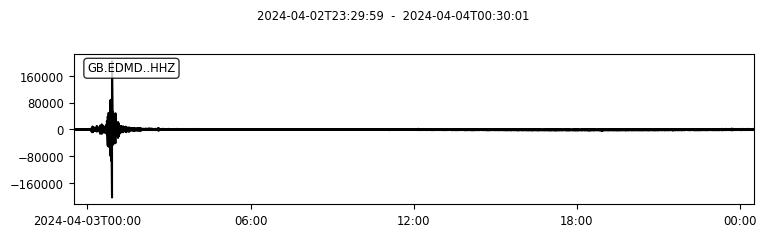

In [3]:
stream = get_stream(date, station)
print(stream)
plot_graph(stream)

**Pre-processing**

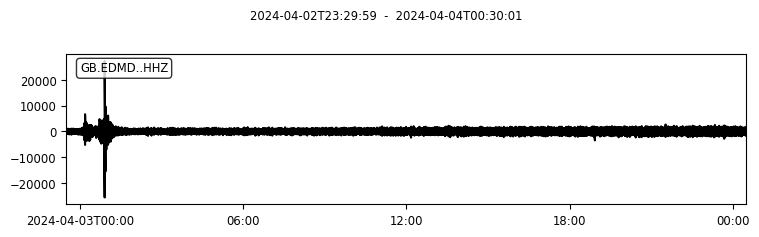

In [4]:
processed_stream = data_processing(stream)
plot_graph(processed_stream)

**Event Identification Using STA/ LTA**

In [10]:
sta_window = 2.0  # Short-time window in seconds
lta_window = 50.0  # Long-time window in seconds
threshold_on = 8.0  # STA/LTA threshold for triggering
threshold_off = 4.0  # STA/LTA threshold for turning off the trigger

earthquakes = detect_earthquakes(processed_stream, sta_window, lta_window, threshold_on, threshold_off)
for quake in earthquakes:
    print(f"Detected earthquake from {quake[0]} to {quake[1]}")

Detected earthquake from 2024-04-03T00:11:01.240000Z to 2024-04-03T00:11:03.350000Z
Detected earthquake from 2024-04-03T00:11:04.570000Z to 2024-04-03T00:11:06.800000Z
Detected earthquake from 2024-04-03T00:11:14.680000Z to 2024-04-03T00:11:19.650000Z
Detected earthquake from 2024-04-03T00:35:55.690000Z to 2024-04-03T00:35:56.850000Z
Detected earthquake from 2024-04-03T00:44:33.240000Z to 2024-04-03T00:44:35.240000Z
Detected earthquake from 2024-04-03T00:50:02.010000Z to 2024-04-03T00:50:03.860000Z
Detected earthquake from 2024-04-03T00:59:10.630000Z to 2024-04-03T00:59:12.770000Z
Detected earthquake from 2024-04-03T00:59:15.660000Z to 2024-04-03T00:59:18.280000Z
Detected earthquake from 2024-04-03T08:36:52.890000Z to 2024-04-03T08:36:56.520000Z
Detected earthquake from 2024-04-03T09:16:32.240000Z to 2024-04-03T09:16:34.200000Z
Detected earthquake from 2024-04-03T23:44:34.100000Z to 2024-04-03T23:44:37.960000Z
Detected earthquake from 2024-04-03T23:46:10.760000Z to 2024-04-03T23:46:13.